## Segment and Cluster Toronto Neighborhoods

### Table of Contents ###
<ul>
<li><a href="#Project Overview">Project Overview</a></li>
<li><a href="#Data Overview">Data Overview</a></li>
<li><a href="#Data Wrangling">Data Wrangling</a></li>
<li><a href="#EDA">Exploratory Data Analysis</a></li>
<li><a href="#Results & Discussion">Results & Discussion</a></li>
<li><a href="#Conclusion">Conclusion</a></li>
</ul>

<a id='Project Overview'></a>
### Project Overview

**The purpose of this project is to leverage Foursquare's API to explore neighborhoods in Toronto, CA in order to segment and cluster them by venue categories. This is a great practice to align residential neighborhoods/boroughs to personal interest's and hobbies. The 'explore'** **function will be used to get the most common venue categories in each neighborhood. *K*-means clustering algorithm will be implemented to cluster the final results. Finally, pythons Folium library will be used to visualize the neighborhoods in Toronto and their emerging clusters.**

<a id='Data Overview'></a>
### Data Overview

**Using data provided by Foursquare, venues and venue categories information will be assessed to determine distinguishing features among boroughs.**

**Data sources will include the web (web scraping), a .csv file specifying geospatial data of the boroughs in Toronto, and data explored utilizing Foursquare's API. Postal code data will be scraped from 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'. A final DataFrame combining all the desired data will be constructed prior to cluster analysis.**

**The cluster analysis k-value will be optimized based on the inital results at k = 5. K-values from 3-10 will ultimately be analyzed.**

In [1]:
# Import required libraries and packages
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.mode.chained_assignment = None

#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import json
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

from PIL import Image
import requests

#!conda install -c conda-forge geocoder -y
import geocoder

# Matplotlib and associated plotting modules
%matplotlib inline
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


<a id='Data Wrangling'></a>
### Data Wrangling

**Below, pandas 'read_html' command is used to import the raw data from the wikipedia link provided. This, however reads all data on the page, so a table to pull data from i.e. "canada[0]" must be specified. This reads the first table in the page.**

In [2]:
# Creating Dataframe from Wiki Table
path = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'    
canada = pd.read_html(path, header=0)
cn_table = canada[0]
cn_table.head()

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


In [3]:
# Store original DataFrame
cn_table_original = cn_table.copy()

**In the first line, the Borough column is replaced with a new column that eliminates all rows with a value of 'Not assigned.' In the second line, a numpy command is used to set all values of 'Not assigned' in the Neighbourhood column equal to the value specified in the adjacent Borough column.**

In [4]:
# Data Wrangling - Filter Borough's and Neighbhorhoods
cn_table = cn_table.query('Borough != "Not assigned"')
cn_table.loc[:,'Neighbourhood'] = np.where(cn_table['Neighbourhood'] == 'Not assigned', cn_table['Borough'], cn_table['Neighbourhood'])
cn_table.head()

,Postcode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights


**Below, the table is grouped by Postcode and an aggregate function is used to combine the remaining columns with a ',' if the Postcode's are identical. For this analysis, # if eighborhoods  in order to analyze venues/living in each neighborhood and not each postal code.**

In [5]:
cn_table = cn_table.groupby('Postcode', as_index=False).agg(lambda x: ', '.join(set(x.dropna())))
cn_table.head()

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Morningside, Guildwood, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [6]:
# Longitude and latitude data from .csv file is read. Column 'Postal Code' is renamed to 'Postcode' so it can be merged with original dataframe.
lat_long_path = 'http://cocl.us/Geospatial_data'
latlongdf= pd.read_csv(lat_long_path)
latlongdf.rename(columns={'Postal Code':'Postcode'},inplace=True)

In [7]:
df = pd.merge(cn_table,latlongdf, on='Postcode')
df.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Morningside, Guildwood, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [8]:
# For analysis, boroughs containing the string 'Toronto' are filtered.
df = df[df['Borough'].str.contains("Toronto")]
df.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
37,M4E,East Toronto,The Beaches,43.676357,-79.293031
41,M4K,East Toronto,"Riverdale, The Danforth West",43.679557,-79.352188
42,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572
43,M4M,East Toronto,Studio District,43.659526,-79.340923
44,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


In [9]:
# Use Nominatim to get geo data for Toronto, CA to use in Folium library.
address = 'Toronto, Canada'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


In [10]:
# Use Folium to render map of Toronto, CA
toronto_map = folium.Map(location=[latitude, longitude], zoom_start=11.2, width = '50%', height = '50%')

for lat, lng, label in zip(df['Latitude'], df['Longitude'], df['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat, lng], radius=5, popup=label, color='blue', fill=True, fill_color='#3186cc', fill_opacity=0.7, 
                        parse_html=False).add_to(toronto_map)  
    
toronto_map;

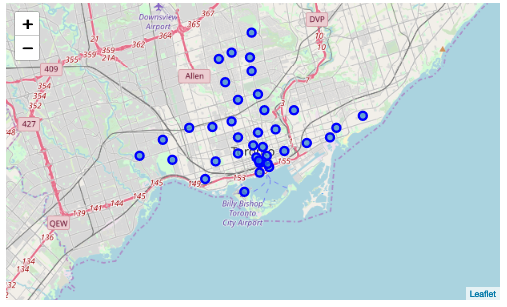

In [11]:
from IPython.display import Image
Image(filename='img1.png')

In [12]:
# Foursqure Access Credentials
CLIENT_ID = 'J0N1KBD4I0OXJBV2ZHCZDJ4WORIA113SPDRNIP30K43V0JBM'
CLIENT_SECRET = 'HXDCOTNNWCLWQAZ4S3FQ4I2T4V5LKIXPLFRFBB5SU2J34NWV'
VERSION = '20180605' # Foursquare API version

In [13]:
LIMIT = 100

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    venues_toronto=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)
            
        # GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_toronto.append([(name, lat, lng, v['venue']['name'], v['venue']['location']['lat'], v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_toronto in venues_toronto for item in venue_toronto])
    nearby_venues.columns = ['Neighbourhood', 'Neighbourhood Latitude', 'Neighbourhood Longitude', 'Venue', 'Venue Latitude', 
                  'Venue Longitude', 'Venue Category']
    
    return(nearby_venues)

In [ ]:
# Pull top venues for each Neighbourhood in Toronto
toronto_venues = getNearbyVenues(names = df['Neighbourhood'], latitudes = df['Latitude'], longitudes = df['Longitude'])

<a id='EDA'></a>
### Exploratory Data Analysis

In [ ]:
toronto_venues.head()

**Assign dummy variables to each neighborhood and venues in that neighborhood in order to take the mean of the data and analyze the frequency of each venue category in a neighborhood.**

In [ ]:
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

toronto_onehot['Neighbourhood'] = toronto_venues['Neighbourhood'] 

fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
toronto_grouped.head()

In [ ]:
# Top 10 venue categories for each neighborhood
num_top_venues = 10

for Neighborhood in toronto_grouped['Neighbourhood']:
    temp = toronto_grouped[toronto_grouped['Neighbourhood'] == Neighborhood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})

In [ ]:
# Sort above data of venues in each neighborhood by most popular.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [ ]:
# Create dataframe of top 10 most common venues in each neighborhoods. 
num_top_venues = 10
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

#### Clustering

In [ ]:
# Initialize 5 k clusters and use KMeans to assign labels to each Neighborhood section.
kclusters = 3

toronto_grouped_clustering = toronto_grouped.drop('Neighbourhood', axis = 1)
kmeans = KMeans(n_clusters = kclusters, random_state = 0).fit(toronto_grouped_clustering)

kmeans.labels_[0:10] 

In [ ]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
toronto_merged = df
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

toronto_merged.head()

In [ ]:
toronto_merged = toronto_merged.dropna(how='any',axis=0) 
toronto_merged['Cluster Labels'] = toronto_merged['Cluster Labels'].astype(int)

#### Cluster Mapping - Folium

In [ ]:
# Plot cluster map of Tornoto
map_clusters = folium.Map(location=[latitude, longitude], zoom_start = 11.2, width = '50%', height = '50%')

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker([lat, lon], radius=5, popup=label, color = rainbow[cluster-1], fill=True, fill_color=rainbow[cluster-1],
                        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters;

In [ ]:
Image(filename='img2.png')

**Cluster Analysis** <br>
**Now, we can examine each cluster and determine the discriminating venue categories that distinguish each cluster.**

#### Cluster 1##

In [ ]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]].head()

#### Cluster 2

In [221]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]].head()

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
37,East Toronto,1,Health Food Store,Coffee Shop,Pub,Neighborhood,Diner,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store
41,East Toronto,1,Greek Restaurant,Coffee Shop,Italian Restaurant,Ice Cream Shop,Yoga Studio,Sports Bar,Juice Bar,Spa,Bookstore,Brewery
42,East Toronto,1,Park,Gym,Italian Restaurant,Pet Store,Coffee Shop,Movie Theater,Pub,Burrito Place,Sandwich Place,Burger Joint
43,East Toronto,1,Café,Coffee Shop,Bakery,Italian Restaurant,Gastropub,American Restaurant,Stationery Store,Juice Bar,Latin American Restaurant,Fish Market
45,Central Toronto,1,Hotel,Food & Drink Shop,Park,Gym,Grocery Store,Sandwich Place,Breakfast Spot,Clothing Store,Burger Joint,Yoga Studio


#### Cluster 3

In [222]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]].head()

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
63,Central Toronto,2,Garden,Yoga Studio,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant


<a id='Results & Discussion'></a>
### Results & Discussion

**K-mean cluster values from 3-8 were analyzed. A 'k' value of 3 showed clear discriminating categories. At a k-value of 3, the following distinguishing features were observed:**<br>
- **Borough's in cluster 1 are primarily composed of outdoor features such as parks, gyms, trails, and swimming.**<br>
- **Borough's in cluster 2 are primarily composed of restaurant, coffee shops, food stores, pubs, etc.**<br>
- **The borough in cluster 3 does not have a distinguishable feature, but gardens, yoga studio, and farmer's market can be associated with this borough.**<br>

**An analysis with a higher k-value can definitely be implemented if the goal is to find a couple of boroughs with a set of distinguishable venue categories. In this case, boroughs in Toronto are very similar, so a k-value of 3 can be considered optimal.**

<a id='Conclusion'></a>
### Conclusion

**The 2 discriminating features from the cluster analysis were food/restaurants and outdoors/entertainment. This analysis can be very helpful if considering a move to the Toronto, CA area. Knowing the top venue categories for each neighborhood can allow a decision on living location based on features such as interests and hobbies.**